## Assigment 4

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from itertools import combinations
from random import sample, seed
from a4_utils import *
%load_ext autoreload
%autoreload 2
seed(100)

### helper functions

In [3]:
def readGrayF64(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

In [4]:
def gaussdx(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) * (-x/(np.sqrt(2*np.pi) * sigma**3))
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(abs(r))).reshape(1, r.shape[0])

def gaussian(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) / (np.sqrt(2*np.pi) * sigma)
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(r)).reshape(1, r.shape[0])

def g_gdx(o=2):
    if o is None:
        o = 2
    return gaussian(o), -gaussdx(o)

def imgDX(I, o=2):
    g, gdx = g_gdx(o)
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g.T), -1, kernel=gdx)

def imgDY(I, o=2):
    g, gdx = g_gdx(o)
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g), -1, kernel=gdx.T)

def imgDXX(I, o=2):
    return imgDX(imgDX(I, o), o)

def imgDXY(I, o=2):
    return imgDY(imgDX(I, o), o)

def imgDYX(I, o=2):
    return imgDX(imgDY(I, o), o)

def imgDYY(I, o=2):
    return imgDY(imgDY(I, o), o)

In [5]:
def nonmaxsuppression(I, nb=1):
    if nb == 0:
        return I

    Is = I.copy()
    box_step = 2*nb
    for y in range(0, Is.shape[0], box_step):
        for x in range(0, Is.shape[1], box_step):
            y_lim = min(y + box_step, Is.shape[0] -1)
            x_lim = min(x + box_step, Is.shape[1] -1)
            neighboruhood = Is[y:y_lim, x:x_lim]
            maxiumum = np.max(neighboruhood)
            maximums = np.argwhere(neighboruhood == maxiumum)
            maximum_index = maximums[len(maximums)//2]
            Is[y:y_lim, x:x_lim] = 0
            Is[y+maximum_index[0], x+maximum_index[1]] = maxiumum
            
    return Is


In [6]:
def hellinger_distance(hist_A, hist_B):
    return np.sum((np.sqrt(hist_A) - np.sqrt(hist_B))**2) ** 0.5 / np.sqrt(2)

### Exercise 1

#### A

In [7]:
def hessian_points(I, o=None, t=None, nb=0):
    Ixx = imgDXX(I, o)
    Iyy = imgDYY(I, o)
    Ixy = imgDXY(I, o)

    detI = np.multiply(Ixx, Iyy) - np.multiply(Ixy, Ixy)

    if t is not None:
        detI[detI < t] = 0
        detI = nonmaxsuppression(detI, nb)
        
    return detI

Text(0.5, 1.0, 'higher sigma')

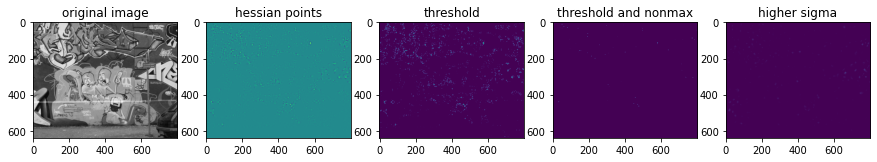

In [8]:
test_points = readGrayF64("./assigments/assigment4/data/graf/graf_a.jpg")
test_points_features = hessian_points(test_points)
test_points_keypoints = hessian_points(test_points, t=0.001)
test_points_keypoints_nonmax = hessian_points(test_points, t=0.01, nb=1)
test_points_keypoints_nonmax2 = hessian_points(test_points, o=6, t=0.001, nb=2)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(test_points, cmap="gray")
axes[0].set_title("original image")

axes[1].imshow(test_points_features)
axes[1].set_title("hessian points")

axes[2].imshow(test_points_keypoints)
axes[2].set_title("threshold")

axes[3].imshow(test_points_keypoints_nonmax)
axes[3].set_title("threshold and nonmax")

axes[4].imshow(test_points_keypoints_nonmax2)
axes[4].set_title("higher sigma")

In [9]:
def plot_with_keypoints(I, points, axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow(I, cmap="gray")
    axes.scatter(points[:, 1], points[:, 0], s=3, c="r")
    axes.set_xlabel("num points: {}".format(len(points)))


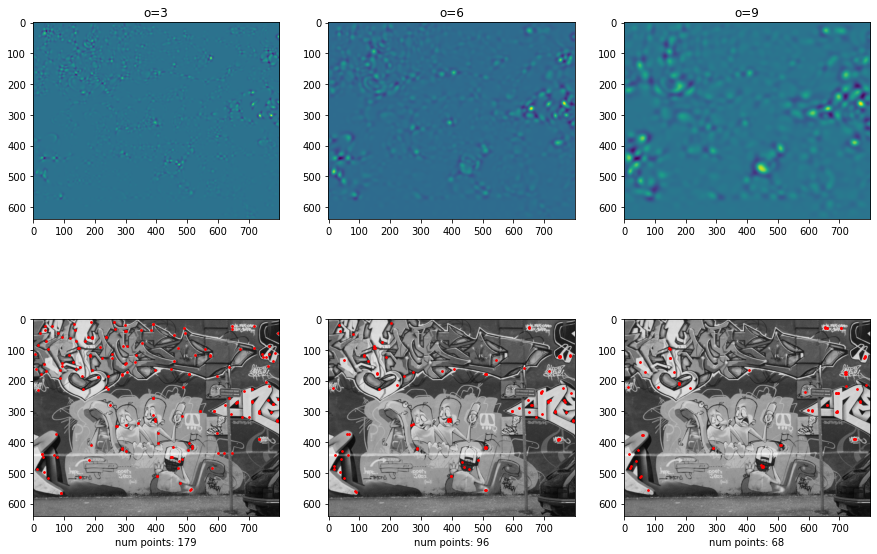

In [10]:
o_options = [3, 6, 9]
t = 0.004
nb = 15

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(o_options)):
    points = hessian_points(test_points, o=o_options[i])

    axes[0, i].imshow(points, cmap="viridis")
    axes[0, i].set_title("o={}".format(o_options[i]))

    axes[1, i].imshow(points, cmap="afmhot")
    keypoints = hessian_points(test_points, o=o_options[i], t=t, nb=nb)
    plot_with_keypoints(test_points, np.argwhere(keypoints > 0), axes[1, i])
        

question 1

#### B

In [11]:
def harris_points(I, o=2, o_after=None, alpha=0.06, t=None, nb=0):
    if o_after is None:
        o_after = 1.6 * o
    afterGK = np.flip(gauss(o_after))
    Ix = imgDX(I, o)
    Iy = imgDY(I, o)
    
    C11 = cv2.filter2D(Ix**2, ddepth=-1, kernel=afterGK)
    C12 = cv2.filter2D(Ix*Iy, ddepth=-1, kernel=afterGK)
    C21 = cv2.filter2D(Iy*Ix, ddepth=-1, kernel=afterGK)
    C22 = cv2.filter2D(Iy**2, ddepth=-1, kernel=afterGK)

    detC = C11*C22 - C12*C21
    traceC = C11 + C22

    value = detC - alpha * (traceC**2)

    if t is not None:
        value[value < t] = 0
        value = nonmaxsuppression(value, nb)
    return value

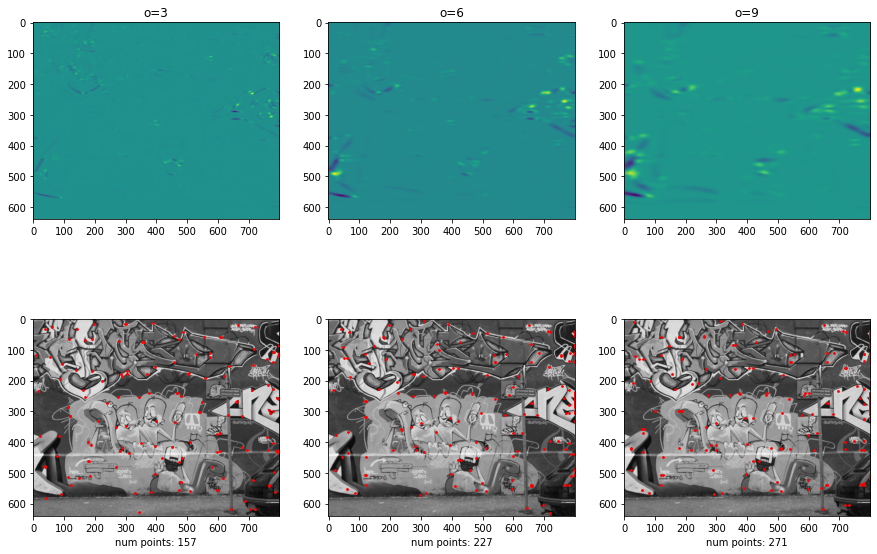

In [12]:
o_options = [3, 6, 9]
t = 10**-6
nb = 30

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(o_options)):
    points = harris_points(test_points, o=o_options[i])

    axes[0, i].imshow(points)
    axes[0, i].set_title("o={}".format(o_options[i]))

    axes[1, i].imshow(points)
    keypoints = harris_points(test_points, o=o_options[i], t=t, nb=nb)
    plot_with_keypoints(test_points, np.argwhere(keypoints > 0), axes[1, i])

in task question

### Exercise 2

#### A

In [13]:
def find_correspondences(descriptorsA, descriptorsB, reverse=False):
    matches = []
    distances = []
    for dAi in range(len(descriptorsA)):
        # default basepoint for comparison
        if not reverse:
            matches.append((dAi, 0))
        else:
            matches.append((0, dAi))
        distances.append(hellinger_distance(descriptorsA[dAi], descriptorsB[0]))

        # find best match for point from A
        for dBi in range(1, len(descriptorsB)):
            distance = hellinger_distance(descriptorsA[dAi], descriptorsB[dBi])
            if distance < distances[-1]:
                if not reverse:
                    matches[-1] = (dAi, dBi)
                else:
                    matches[-1] = (dBi, dAi)
                distances[-1] = distance
    return matches

In [14]:
graf_a_small = readGrayF64("./assigments/assigment4/data/graf/graf_a_small.jpg")
graf_b_small = readGrayF64("./assigments/assigment4/data/graf/graf_b_small.jpg")
graf_a_small.shape, graf_b_small.shape

((289, 340), (289, 340))

In [15]:
graf_a_small_keypoints = np.argwhere(harris_points(graf_a_small, o=6, t=10**-6, nb=10) > 0)
graf_b_small_keypoints = np.argwhere(harris_points(graf_b_small, o=6, t=10**-6, nb=10) > 0)
len(graf_a_small_keypoints), len(graf_b_small_keypoints)

(224, 207)

In [16]:
graf_a_small_descriptors = simple_descriptors(graf_a_small, graf_a_small_keypoints[:, 0], graf_a_small_keypoints[:, 1])
graf_b_small_descriptors = simple_descriptors(graf_b_small, graf_b_small_keypoints[:, 0], graf_b_small_keypoints[:, 1])
len(graf_a_small_descriptors), len(graf_b_small_descriptors)

(224, 207)

In [17]:
graf_a_b_small_correspondences = find_correspondences(graf_a_small_descriptors, graf_b_small_descriptors)
correspondences_indexes = list(zip(*graf_a_b_small_correspondences))

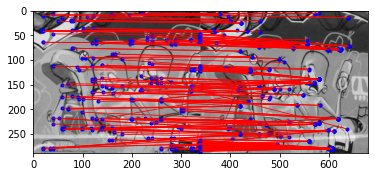

In [18]:
graf_small_a_points_ordered = np.take(graf_a_small_keypoints, correspondences_indexes[0], axis=0)
graf_small_b_points_ordered = np.take(graf_b_small_keypoints, correspondences_indexes[1], axis=0)

display_matches(graf_a_small, graf_small_a_points_ordered, graf_b_small, graf_small_b_points_ordered)

#### B

In [19]:
def simple_descriptors_wrapper(I, Y, X):
    points = np.array((Y, X)).T
    return simple_descriptors(I, Y, X), points

def find_matches(IA, IB, o=6, t=10**-6, nb=10, descriptors=simple_descriptors_wrapper):
    keypoints_A = np.argwhere(harris_points(IA, o=o, t=t, nb=nb) > 0)
    keypoints_B = np.argwhere(harris_points(IB, o=o, t=t, nb=nb) > 0)

    descriptorsA, keypoints_A = descriptors(IA, keypoints_A[:, 0], keypoints_A[:, 1])
    descriptorsB, keypoints_B = descriptors(IB, keypoints_B[:, 0], keypoints_B[:, 1])

    correspondences_A_B = find_correspondences(descriptorsA, descriptorsB)
    correspondences_B_A = find_correspondences(descriptorsB, descriptorsA, reverse=True)

    symetric_correspondences = set(correspondences_A_B).intersection(set(correspondences_B_A))

    correspondences_info = list(zip(*symetric_correspondences))

    points_A_ordered = np.take(keypoints_A, correspondences_info[0], axis=0)
    points_B_ordered = np.take(keypoints_B, correspondences_info[1], axis=0)

    return points_A_ordered, points_B_ordered

In [20]:
pointsA, pointsB = find_matches(graf_a_small, graf_b_small, o=2, t=10**-6, nb=15)
len(pointsA), len(pointsB)

(46, 46)

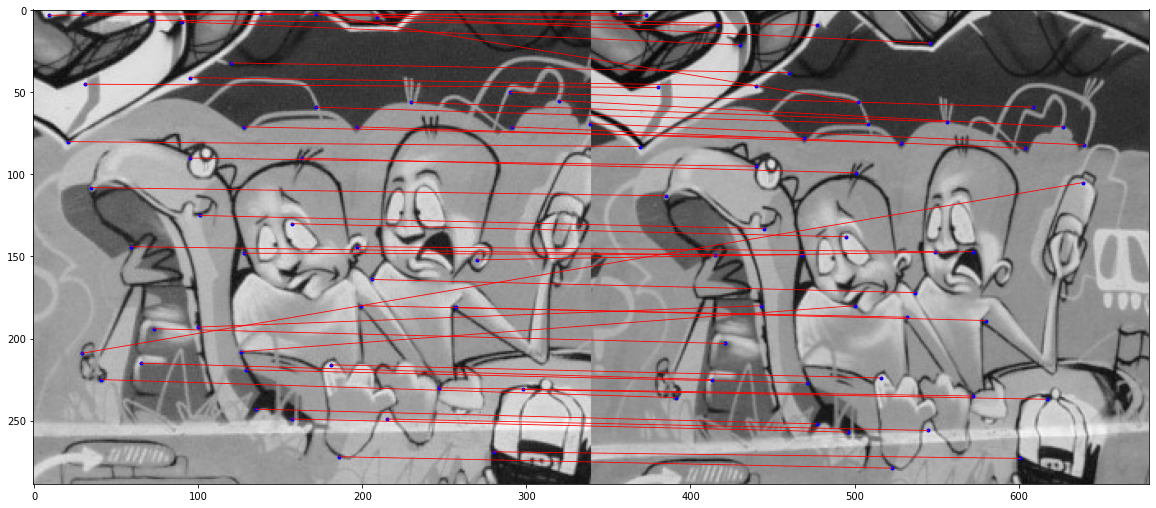

In [21]:
fig = plt.figure(figsize=(20, 10))
display_matches(graf_a_small, pointsA, graf_b_small, pointsB)

question

### Exercise 3

#### A

question

question

In [22]:
def estimate_homography(pointsA, pointsB):
    # construct matrix A of homogenous system Ah = 0
    A = np.zeros((2*len(pointsA), 9))
    for i in range(len(pointsA)):
        yA, xA = pointsA[i]
        yB, xB = pointsB[i]

        A[2*i] = [xA, yA, 1, 0, 0, 0, -xB*xA, -xB*yA, -xB]
        A[2*i +1] = [0, 0, 0, xA, yA, 1, -yB*xA, -yB*yA, -yB]

    # preform SVD on A
    _, _, VT = np.linalg.svd(A)

    # compute h
    h = VT[-1, :] / VT[-1, -1]

    # reshape h to 3x3 matrix
    H = h.reshape((3, 3))
    return H  

In [23]:
newyork_a = readGrayF64("./assigments/assigment4/data/newyork/newyork_a.jpg")
newyork_b = readGrayF64("./assigments/assigment4/data/newyork/newyork_b.jpg")
newyork_a.shape, newyork_b.shape

((250, 250), (250, 250))

In [24]:
ny_points = np.loadtxt("./assigments/assigment4/data/newyork/newyork.txt")
ny_pointsA = list(zip(ny_points[:, 1], ny_points[:, 0]))
ny_pointsB = list(zip(ny_points[:, 3], ny_points[:, 2]))

In [25]:
ny_H = estimate_homography(ny_pointsA, ny_pointsB)
ny_H

array([[ 7.68066321e-01, -6.37561940e-01,  1.08599883e+02],
       [ 6.42462642e-01,  7.41785866e-01, -3.30904536e+01],
       [ 2.51437379e-05, -8.30833330e-05,  1.00000000e+00]])

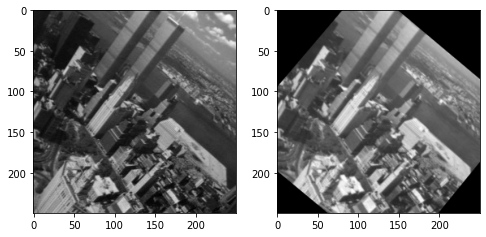

In [26]:
newyork_a_wrapped = cv2.warpPerspective(newyork_a, ny_H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(newyork_a_wrapped, cmap="gray")

In [27]:
graf_a = readGrayF64("./assigments/assigment4/data/graf/graf_a.jpg")
graf_b = readGrayF64("./assigments/assigment4/data/graf/graf_b.jpg")
graf_a.shape, graf_b.shape

((640, 800), (640, 800))

In [28]:
g_points = np.loadtxt("./assigments/assigment4/data/graf/graf.txt")
g_pointsA = list(zip(g_points[:, 1], g_points[:, 0]))
g_pointsB = list(zip(g_points[:, 3], g_points[:, 2]))

In [29]:
g_H = estimate_homography(g_pointsA, g_pointsB)
g_H

array([[ 1.27437554e+00,  3.43710625e-02,  6.81319745e+01],
       [ 2.23945482e-01,  1.21445700e+00, -7.64078762e+01],
       [ 5.99335420e-04,  4.25744503e-05,  1.00000000e+00]])

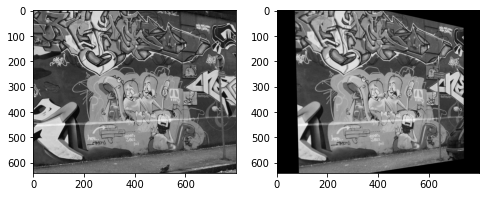

In [30]:
graf_A_wrapped = cv2.warpPerspective(graf_a, g_H, (graf_a.shape[1], graf_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(graf_b, cmap="gray")
axes[1].imshow(graf_A_wrapped, cmap="gray")

#### B

In [31]:
ny_pointsA, ny_pointsB = find_matches(newyork_a, newyork_b, o=4, t=10**-8, nb=10)
len(ny_pointsA), len(ny_pointsB)

(46, 46)

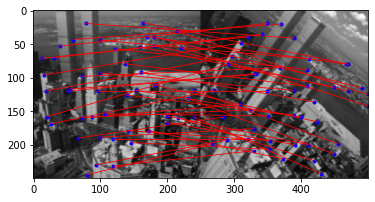

In [32]:
display_matches(newyork_a, ny_pointsA, newyork_b, ny_pointsB)
# we can clearly see that some points are very good matches, but some are terrible (for example short line at the top middle of the image)

In [41]:
def euclidian(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def inliers(pointsA, pointsB, H, t):
    points_idx = []
    perror = 0
    for i in range(len(pointsA)):
        v = np.matmul(H, [pointsA[i][1], pointsA[i][0], 1]) 
        v = v / v[-1]

        err = euclidian(v[0], v[1], pointsB[i][1], pointsB[i][0])
        perror += err
        if err < t:
            points_idx.append(i)
    return points_idx, perror / len(pointsA)

def ransac(pointsA, pointsB, k=4, samples=4, t=0.001, p=0.99, e=0.1, expected_err=5):
    # subtask C*
    if k is None:
        # 1 - p = (1 - (1 - e)**samples)**k
        # (1 - e)**samples --> probability of all samples being inliers
        # 1 - (1 - e)**samples --> probability of at least one sample being an outlier
        # (1 - (1 - e)**samples)**k --> probability of all k samples having at least one outlier
        # 1 - p --> probability of drawing k samples with all of them having at least one outlier
        k = np.ceil(np.log(1 - p) / np.log(1 - (1 - e)**samples)).astype(int)
        print(f"Automatically detetmined k = {k} using p = {p}, e = {e} and samples = {samples}")

    options = range(len(pointsA))
    match_sets = combinations(options, r=samples)
    k_match_sets = sample(list(match_sets), k=k)

    best_inliers = []
    best_H = None
    best_perror = None
    for matches in k_match_sets:
        H = estimate_homography(np.take(pointsA, matches, axis=0), np.take(pointsB, matches, axis=0))

        inliers_idx, _ = inliers(pointsA, pointsB, H, t)
        if len(inliers_idx) > len(pointsA) * 0.5:
            H = estimate_homography(np.take(pointsA, inliers_idx, axis=0), np.take(pointsB, inliers_idx, axis=0))
            _, perror = inliers(pointsA, pointsB, H, t)
            if best_perror is None or perror < best_perror:
                best_perror = perror
                best_H = H
                best_inliers = inliers_idx
                # subtask C*
                # add break condition if a sufficient match is found
                if best_perror < expected_err:
                    break
    return best_H, best_inliers, best_perror


In [34]:
seed(10000) # seed 200 with k = 10 works well
H, inliers_idx, perror = ransac(ny_pointsA, ny_pointsB, k=100, t=20)
perror, len(inliers_idx)

(9.979907610212132, 37)

In [35]:
H

array([[ 7.93668710e-01, -5.99145650e-01,  1.13457983e+02],
       [ 6.96259003e-01,  9.39851091e-01, -4.88945317e+01],
       [ 1.56993922e-04,  6.03832999e-04,  1.00000000e+00]])

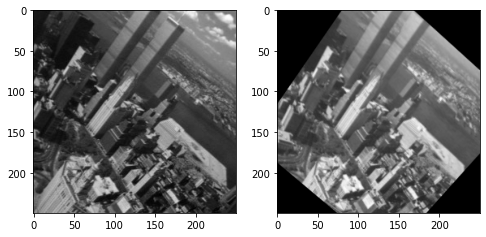

In [36]:
ny_wrapped = cv2.warpPerspective(newyork_a, H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(ny_wrapped, cmap="gray")

question

#### C

In [54]:
H, inliers_idx, perror = ransac(ny_pointsA, ny_pointsB, k=None, t=20, p=0.99, e=0.5, expected_err=10)
perror, len(inliers_idx)

Automatically detetmined k = 72 using p = 0.99, e = 0.5 and samples = 4


(10.091714710132091, 32)

In [55]:
H

array([[ 8.07487916e-01, -6.30263412e-01,  1.10598952e+02],
       [ 7.15960003e-01,  9.31552354e-01, -5.30695489e+01],
       [ 1.32973965e-04,  4.29607803e-04,  1.00000000e+00]])

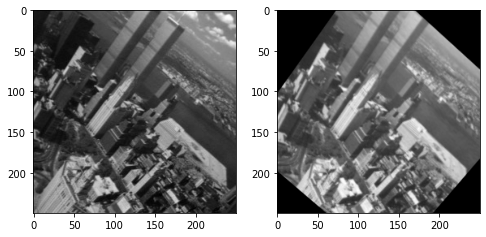

In [56]:
ny_wrapped = cv2.warpPerspective(newyork_a, H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(ny_wrapped, cmap="gray")

#### D

In [244]:
def normalise_scale(points):
    p = np.empty((len(points), 3))
    for i, point in enumerate(points):
        f = 1
        if point.shape[0] == 3:
            f = point[2]
        p[i] = np.array([point[0] / f, point[1] / f, 1])
    return p

def weighted_least_squares(A, B, W):
    b = A.T @ np.multiply(W, B)
    a = A.T @ np.multiply(W, A)
    return np.linalg.inv(a) @ b

def transform_error(A, B, H, W):
    return (np.multiply(W, (normalise_scale(A @ H) - B)))**2

def reweighted_least_squares(pointsA, pointsB, k=100, threshold=100):
    pointsA = normalise_scale(pointsA)
    pointsB = normalise_scale(pointsB)

    weights = np.ones(pointsA.shape)

    e = None
    steps = 0
    for steps in range(k):
        H = weighted_least_squares(pointsA, pointsB, weights)
        errors = transform_error(pointsA, pointsB, H, weights)
        errors[errors <= 10**-6] = 10**-6
        weights = errors**-1
        e = np.sum(errors)
        if np.sum(errors) < threshold:
            break
        print(e)
    return H, e, steps
    

In [245]:
N = 4

selected_ny_pointsA = ny_pointsA[:N]
selected_ny_pointsB = ny_pointsB[3:N+3]

In [246]:
H, e, steps = reweighted_least_squares(selected_ny_pointsA, selected_ny_pointsB, 100)
H, e, steps

14339.112433236167
254.97190051294086
976473558.3741544
1.3794848185569152e+16
2.906770337386436e+24
2.802773127041006e+47
3.961817330158528e+45
8.286190647408401e+43
1.3971360600394626e+46
4.0253483057700266e+44
2.0607049142161277e+46
7.106388893447629e+117
1.1521409244970601e+264
4.891438797187115e+43
1.947431087617163e+46
1.9551958507331247e+44
1.9446856159399048e+46
3.1194990399369295e+45
1.933742380127688e+46
3.4272104534775075e+44
1.0541033190656762e+116
1.5062256204800755e+44
2.885286461053677e+45
1.3931415096565588e+116
2.0100527391497496e+46
3.3327363427546304e+45
2.2071447569558595e+46
1.7859330303848246e+43
4.6152652180014725e+45
5.737243479937644e+43
2.9539843853909723e+114
3.028168412463166e+43
1.8659023395389138e+45
2.0422144063474207e+44
2.1216392397484348e+46
1.4852142997050954e+44
1.1221401768813516e+46
1.1540849222021382e+44
1.1953006823579568e+115
7.933009087416461e+43
5.122296979432334e+46
1.1042298671089504e+44
2.4811203959437847e+46
3.173669860788151e+44
5.6931136

(array([[-9.21409720e-01, -3.24774836e+50, -4.15383749e+34],
        [ 8.50225491e-53,  4.61800345e-01,  6.93889390e-18],
        [ 2.85486248e-50,  7.21774819e+01,  1.00000000e+00]]),
 2.4452638766765507e+44,
 99)

In [248]:
normalise_scale(ny_pointsA)[:3]

array([[192., 118.,   1.],
       [167., 199.,   1.],
       [ 93., 100.,   1.]])

In [247]:
mapped_points = normalise_scale(ny_pointsA)[:3] @ H
mapped_points

array([[-1.76910666e+02, -6.23567685e+52, -7.97536797e+36],
       [-1.53875423e+02, -5.42373976e+52, -6.93690860e+36],
       [-8.56911039e+01, -3.02040597e+52, -3.86306886e+36]])

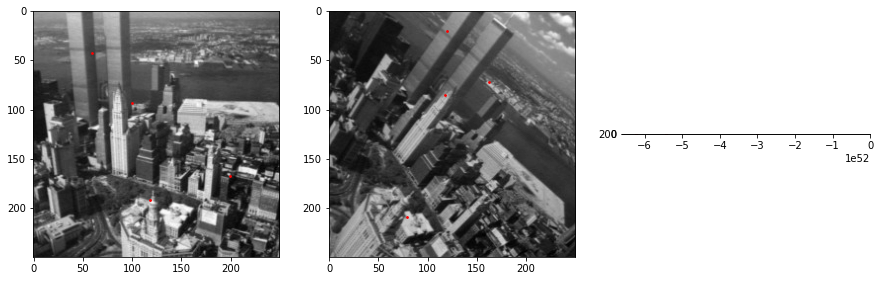

In [227]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

axes[0].imshow(newyork_a, cmap="gray")
axes[0].scatter(selected_ny_pointsA[:, 1], selected_ny_pointsA[:, 0], c="r", s=3)

axes[1].imshow(newyork_b, cmap="gray")
axes[1].scatter(selected_ny_pointsB[:, 1], selected_ny_pointsB[:, 0], c="r", s=3)

axes[2].imshow(newyork_b, cmap="gray")
axes[2].scatter(mapped_points[:, 1], mapped_points[:, 0], c="r", s=3)

### SIFT

In [ ]:
import sift
import importlib
importlib.reload(sift)
Sift = sift.Sift

In [ ]:
eiffel_tower = readGrayF64("./assigments/assigment4/data/eiffel_tower.jpg")
eiffel_tower = cv2.resize(eiffel_tower, (0, 0), fx=0.5, fy=0.5)
eiffel_tower.shape

(800, 600)

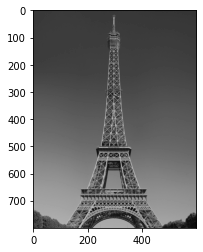

In [ ]:
plt.imshow(eiffel_tower, cmap="gray")

In [ ]:
levels = 10
sigma = 1.6
sift = Sift(octaves=1, levels=levels, sigma0=sigma, sigmaS=1.2)
sift.load_image(eiffel_tower)

In [ ]:
pyramid = sift._dog_pyramid()
pyramid.shape

(10, 800, 600)

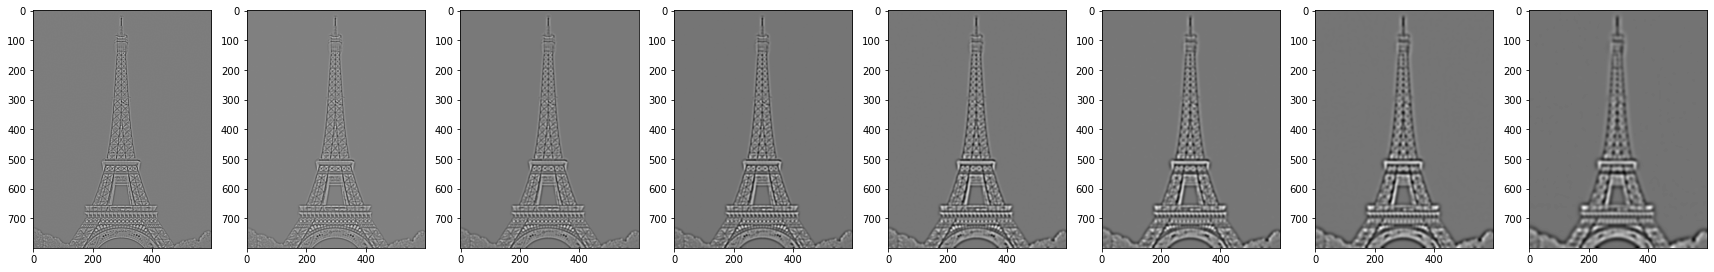

In [ ]:
plots = 8
fig, axes = plt.subplots(1, plots, figsize=(30, 10))

for i in range(plots):
    axes[i].imshow(pyramid[i], cmap="gray")

In [ ]:
def visulize_keypoints(img, keypoints):
    _ = plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap="gray")
    plt.scatter(keypoints[:, 2], keypoints[:, 1], s=10 * sigma ** keypoints[:, 0], fc='none', ec='r')
    
    if keypoints.shape[1] > 3:
        U = np.cos(keypoints[:, 3])
        V = np.sin(keypoints[:, 3])
        S = 2 / keypoints[:, 4]
        plt.quiver(keypoints[:, 2], keypoints[:, 1], U, V, angles='xy', color='y', scale=S, headwidth=1, width=0.0025)

In [ ]:
pyramid_maxima = sift._maxima_in_scale_space(pyramid)
initial_keypoints = np.argwhere(pyramid_maxima)
len(initial_keypoints)

925

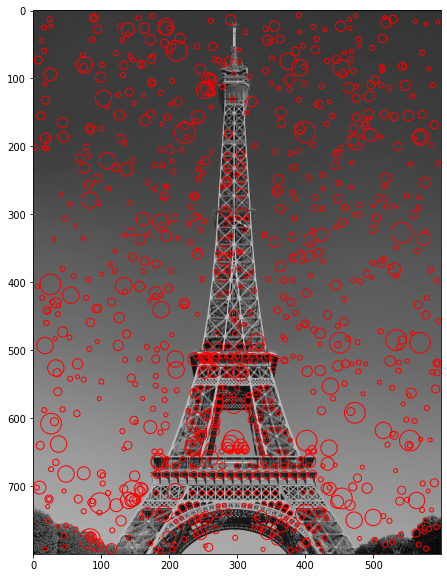

In [ ]:
visulize_keypoints(eiffel_tower, initial_keypoints)

In [ ]:
keypoints_s = sift._reject_weak_points(initial_keypoints, 0.03)
len(keypoints_s)

315

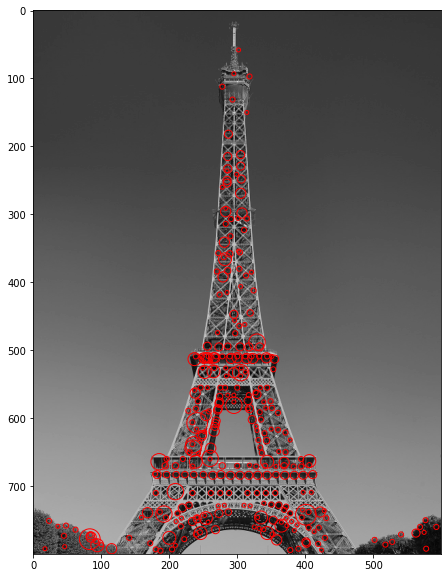

In [ ]:
visulize_keypoints(eiffel_tower, keypoints_s)

In [ ]:
hr = sift._harris_response()
hr.max(), hr.min(), hr.mean()

(2.4248917770755885, -0.816962585731846, 0.02525781663938967)

In [ ]:
keypoints = sift._reject_edge_points(keypoints_s, 0.025)
len(keypoints)

141

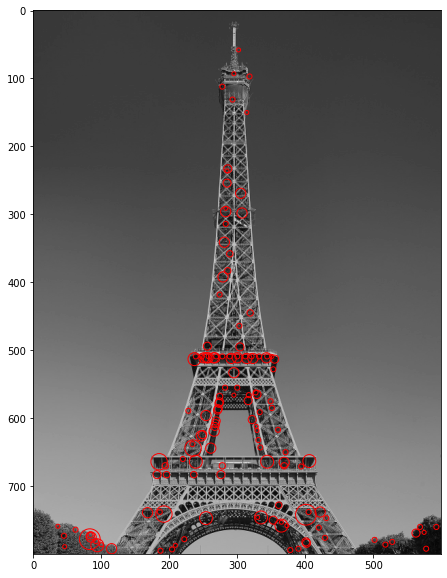

In [ ]:
visulize_keypoints(eiffel_tower, keypoints)

In [ ]:
keypoints_o = sift._get_orientations(keypoints)

In [ ]:
len(keypoints_o)

264

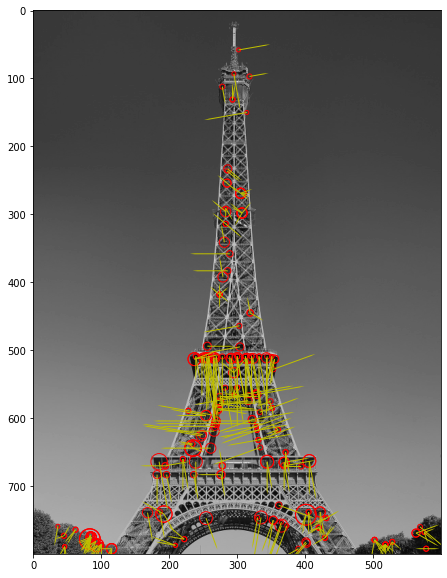

In [ ]:
visulize_keypoints(eiffel_tower, keypoints_o)

In [ ]:
eiffel_tower_descriptors, keypoints_o_f = sift.describe(keypoints_o)

In [ ]:
eiffel_tower_descriptors[0].shape, len(keypoints_o_f), len(keypoints_o)

((128,), 237, 264)

In [ ]:
eiffel_tower_smaller = readGrayF64("./assigments/assigment4/data/eiffel_tower_smaller.jpg")
eiffel_tower_smaller.shape

(980, 980)

In [ ]:
sift.load_image(eiffel_tower_smaller)
ets_keypoints = sift.detect_keypoints(0.03, 0.025)
len(ets_keypoints)

2005

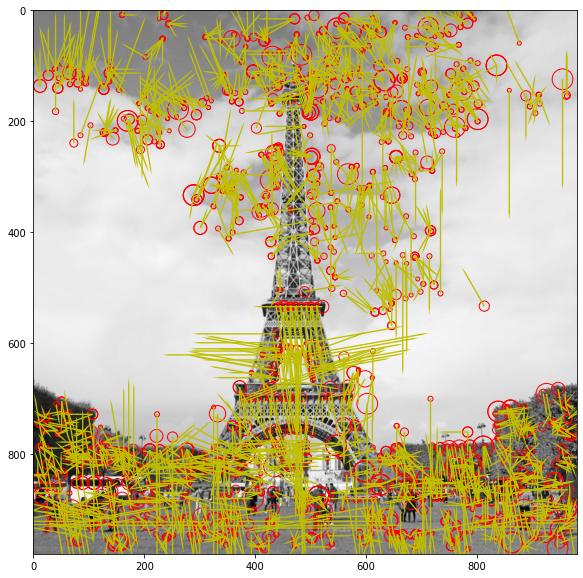

In [ ]:
visulize_keypoints(eiffel_tower_smaller, ets_keypoints)

In [ ]:
eiffel_tower_rotated = readGrayF64("./assigments/assigment4/data/eiffel_tower_rotated.jpg")
eiffel_tower_rotated = cv2.resize(eiffel_tower_rotated, (0, 0), fx=0.75, fy=0.75)
sift.load_image(eiffel_tower_rotated)
eiffel_tower_rotated.shape

(600, 900)

In [ ]:
sift.load_image(eiffel_tower_rotated)
etr_keypoints = sift.detect_keypoints(0.03, 0.025)
len(etr_keypoints)

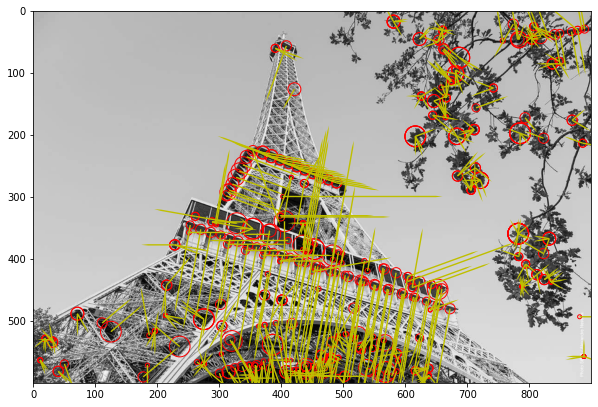

In [ ]:
visulize_keypoints(eiffel_tower_rotated, etr_keypoints)

In [ ]:
efr_descriptors, etr_keypoints_f = sift.describe(etr_keypoints)

In [ ]:
efr_descriptors[0].shape, len(etr_keypoints_f), len(etr_keypoints)

((128,), 450, 486)

In [ ]:
corr_et_etr = find_correspondences(eiffel_tower_descriptors, efr_descriptors)

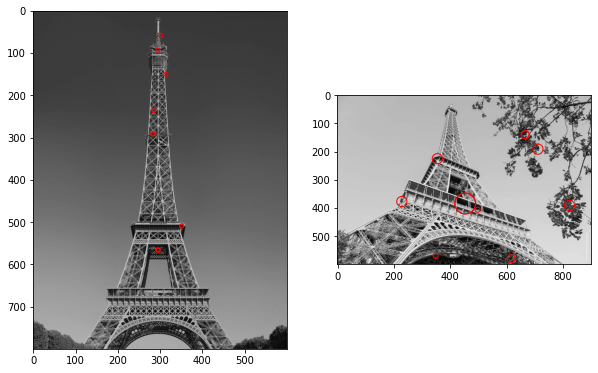

In [ ]:
N = 11
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(eiffel_tower, cmap="gray")
axes[1].imshow(eiffel_tower_rotated, cmap="gray")

for i in range(N):
    matched_et = keypoints_o_f[corr_et_etr[i][0]]
    axes[0].scatter(matched_et[2], matched_et[1], s=10 * sigma ** matched_et[0], fc='none', ec='r')

    matched_etr = etr_keypoints_f[corr_et_etr[i][1]]
    axes[1].scatter(matched_etr[2], matched_etr[1], s=10 * sigma ** matched_etr[0], fc='none', ec='r')
